In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import geopandas as gpd


In [2]:
files = glob.glob('data/*.csv')
files

['data/census_pop_data_1870_1950.csv',
 'data/census_pop_data_1960_2010.csv',
 'data/pertussis_US_monthly_data.csv']

In [3]:
pertussis_monthly = pd.read_csv(files[2], header =0)
# print(pertussis_monthly.columns)
states_monthly= pertussis_monthly.columns[2:]
print(len(states_monthly))
colors = cm.RdYlGn(np.linspace(0,1,len(states_monthly)))

pertussis_monthly = pertussis_monthly.replace('-', np.nan)
pertussis_monthly = pertussis_monthly.astype('float')
pertussis_monthly['sum_states'] = pertussis_monthly[states_monthly].sum(axis = 1,skipna=True)
pertussis_monthly['mean_states'] = pertussis_monthly[states_monthly].mean(axis = 1,skipna=True)

pertussis_monthly['Time'] = pertussis_monthly['YEAR'] + pertussis_monthly['MONTH']/12
print(pertussis_monthly['Time'].min(), pertussis_monthly['Time'].max())

49
1951.0833333333333 2012.5833333333333


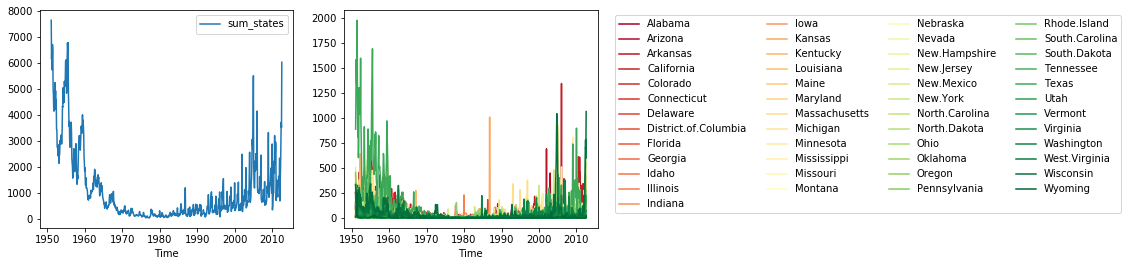

In [4]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
pertussis_monthly.plot(x='Time', y = 'sum_states', ax = ax[0])

pertussis_monthly.plot( x='Time',y=states_monthly, ax = ax[1], color = colors)
ax[1].legend(ncol = 4,bbox_to_anchor=(1.05, 1))

In [5]:
pertussis_monthly.columns = [x.replace('.', ' ').upper() for x in pertussis_monthly.columns]
states_monthly= pertussis_monthly.columns[2:-3]

In [6]:
pertussis_yearly = pertussis_monthly.groupby('YEAR').sum()

In [7]:
files_pop = glob.glob('data/*census*.csv')
#clean data
df_1 = pd.read_csv(files_pop[0])
df_1 = df_1.replace(' Oklahoma[m]', ' Oklahoma')
df_1 = df_1.replace('[n]', '')

df_2 =  pd.read_csv(files_pop[1])
df_2 = df_2.replace('[n]', '')

[x for x in df_2['Name'].unique() if x not in df_1['Name'].unique()]

[' Northern Mariana Islands [w]',
 'Trust Territory of the Pacific Islands Pacific Trust Territory [p][x]',
 ' Palau [y][z]']

In [8]:
df_1.loc[df_1['Name'] == ' Oklahoma', '1890'] = 258657
df_1.loc[df_1['Name'] == ' Oklahoma', '1900'] = 790391

In [9]:
pop_census = df_2.merge( df_1, left_on='Name',right_on='Name', how='left')
pop_census['Name'] = [x[1:].upper() for x in pop_census['Name']]

In [10]:
pop_census = pop_census.set_index('Name').T

In [11]:
pop_census['GEORGIA'] = pop_census['EORGIA (U.S. STATE) GEORGIA']

In [12]:
pop_census.index = pop_census.index.astype('int')

In [13]:
pop_census = pop_census.replace('[n]','')

In [14]:
pop_census = pop_census.replace(' ', np.nan)
pop_census = pop_census.astype('float')
pop_census =pop_census.sort_index() 

In [15]:
repeat_census = pop_census.loc[pop_census.index.repeat(10)].reset_index(drop=True)
repeat_census = repeat_census.set_index(np.arange(1870, 2020))
# repeat_census

In [16]:
prop_diff = (pop_census.diff(axis = 0)/10).shift(-1)
prop_diff.loc[2010, :] =0 

In [17]:
repeat_increase = prop_diff.loc[prop_diff.index.repeat(10)].reset_index(drop=True)
repeat_increase = repeat_increase.multiply(list(np.arange(0,10))*15, axis =0)
repeat_increase = repeat_increase.set_index(np.arange(1870, 2020))

In [18]:
census_yearly = (repeat_census+ repeat_increase)

In [19]:
pertussis_monthly['YEAR'] = pertussis_monthly['YEAR'].astype(int)

In [20]:
states = [state for state in census_yearly.columns if state in states_monthly]

In [21]:
incidence_monthly =(pertussis_monthly.set_index('YEAR')[states]/census_yearly[states]).loc[1951:2013].reset_index()

In [22]:
incidence_monthly['YEAR'] = pertussis_monthly['YEAR'].astype(int)
incidence_monthly['MONTH'] = pertussis_monthly['MONTH'].astype(int)
incidence_monthly['TIME'] = pertussis_monthly['TIME'].astype(float)
incidence_monthly['sum_states'] = incidence_monthly[states].sum(axis=1,skipna=True)
incidence_monthly['mean_states'] = incidence_monthly[states].mean(axis=1,skipna=True)

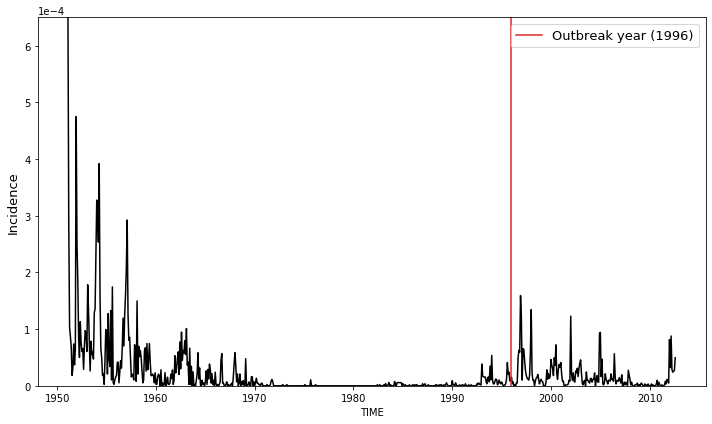

In [23]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, figsize = (10, 6))
incidence_monthly.plot(ax=ax,x='TIME', y='VERMONT', c = 'k', legend = False, label ='')
ax.set_ylabel('Incidence', fontsize = 13)
ax.plot([1996, 1996], [0, 0.00065], c='tab:red', label ='Outbreak year (1996)')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax.set_ylim([0, 0.00065])

ax.legend(loc='upper right', fontsize = 13)
fig.tight_layout()
fig.savefig('vermont_incidence.pdf')

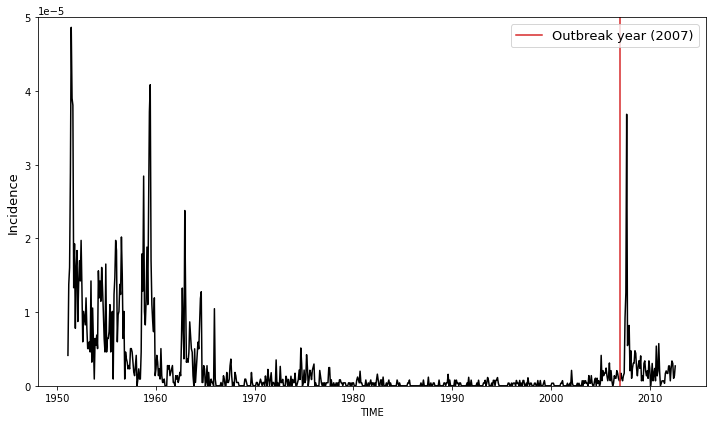

In [24]:
fig, ax = plt.subplots(1, figsize = (10, 6))
incidence_monthly.plot(ax=ax,x='TIME', y='MISSISSIPPI', c = 'k', legend = False, label ='')
ax.set_ylabel('Incidence', fontsize = 13)
ax.plot([2007, 2007], [0, 0.00005], c='tab:red', label ='Outbreak year (2007)')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax.set_ylim([0, 0.00005])
ax.legend(loc='upper right', fontsize = 13)
fig.tight_layout()
fig.savefig('mississi_incidence.pdf')

In [25]:

detrend_monthly =incidence_monthly[states].subtract(incidence_monthly['mean_states'].values, 
                                                            axis = 'rows')
detrend_monthly['TIME'] = incidence_monthly['TIME']

In [26]:
detrend_monthly =incidence_monthly[states].subtract(incidence_monthly['mean_states'].values, 
                                                            axis = 'rows')
detrend_monthly['TIME'] = incidence_monthly['TIME']
detrend_monthly = detrend_monthly.set_index('TIME')

In [27]:
ktau_state_all = {}
ktau_state_1991 = {}
for state in states:
    state_data = detrend_monthly.reset_index()
    state_data = state_data[['TIME', state]]
    ktau_state_all[state] = state_data.corr(method = 'kendall').loc['TIME', state]
    ktau_state_1991[state] = state_data.loc[state_data['TIME']>1991].corr(method = 'kendall').loc['TIME', state]


In [28]:
df_ktau = pd.concat([pd.DataFrame(ktau_state_all, index = [1]
            ), pd.DataFrame(ktau_state_1991, index=[1991])])
df_ktau = df_ktau.T
df_ktau = df_ktau.reset_index()
# df_ktau

In [29]:
us_states = gpd.read_file(glob.glob("data/States_shapefile-shp/*.shp" )[0])
us_states.shape

(51, 7)

In [30]:
state_plots =[x for x in us_states['State_Name'].values if x not in ['ALASKA', 'HAWAII']]

In [31]:
us_states = us_states.set_index('State_Name').loc[state_plots].reset_index()

In [32]:
incidence_yearly = (pertussis_monthly.groupby('YEAR').sum()[states]/census_yearly[states]).loc[pertussis_monthly.groupby('YEAR').sum()[states].index.values]

In [33]:
for year in range(1991, 2010):
#     incidence_year = incidence_monthly.groupby('index').sum().loc[int(year),:].to_frame()
    incidence_year = incidence_yearly.loc[int(year),:].to_frame()
    incidence_year = incidence_year.reset_index()
    us_states = us_states.merge(incidence_year, left_on='State_Name', right_on='index', how='left')


0.0002806401047119293 -5.850728449717738e-05


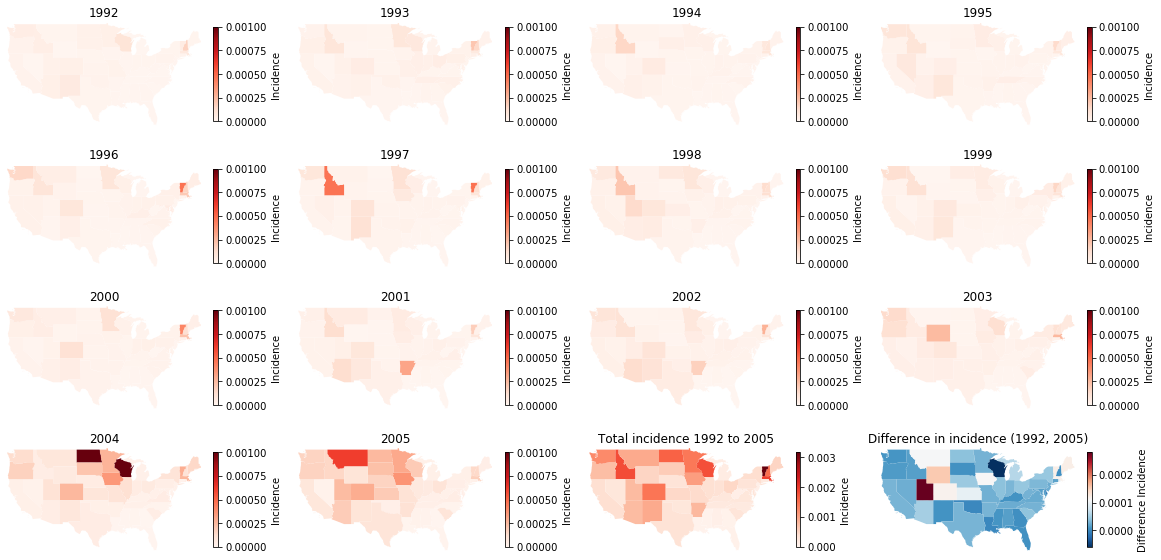

In [34]:
fig, ax = plt.subplots(4,4,figsize = (20, 10))
ax = ax.ravel()
for index_year, year in enumerate(range(1992, 2006)):
    us_states.plot(column = year,legend = True, 
                     vmin = 0, vmax =    0.001,
                   cmap = 'Reds', 
                      legend_kwds={'shrink': 0.8, 'label': 'Incidence'
                                  }, ax = ax[index_year])
    ax[index_year].axis('off')

    ax[index_year].margins(0)
    ax[index_year].set_title(str(year))
    if index_year == 13:
        sum_00_09 = us_states[[int(x) for x in range(1992,2006)]].sum(axis=1).values
        us_states['sum_00_09'] = sum_00_09
        vmax = max(sum_00_09)
        us_states.plot(column = 'sum_00_09',legend = True, 
                     vmin = 0, vmax =    vmax,
                   cmap = 'Reds', 
                      legend_kwds={'shrink': 0.8, 'label': 'Incidence'
                                  }, ax = ax[index_year+1])
        ax[index_year+1].axis('off')

        ax[index_year+1].margins(0)
        ax[index_year+1].set_title('Total incidence 1992 to 2005')
        
        diff_00_09 = us_states[2006].values-us_states[1992].values
        us_states['diff_00_09'] = diff_00_09
        vmax = max(diff_00_09)
        vmin = min(diff_00_09)
        print(vmax, vmin)
        us_states.plot(column = 'diff_00_09',legend = True, 
                     vmin = vmin, vmax =    vmax,
                   cmap = 'RdBu_r', 
                      legend_kwds={'shrink': 0.8, 'label': 'Difference Incidence'
                                  }, ax = ax[index_year+2])
        ax[index_year+2].axis('off')

        ax[index_year+2].margins(0)
        ax[index_year+2].set_title('Difference in incidence (1992, 2005)')

In [35]:
def bin_low_med_high_vhigh(df,colname, 
                           low_thresh, medium_thresh, 
                           high_thresh):
    arr = df[colname].values
    
    df['bin'+str(colname)] = 1
    df.loc[df[colname] <=low_thresh,
            'bin'+str(colname)] = 'Low'
    df.loc[((df[colname] >low_thresh) &
            (df[colname] <=medium_thresh)),
            'bin'+str(colname) ] = 'Medium'
    df.loc[((df[colname] >medium_thresh) &
            (df[colname] <=high_thresh)),
            'bin'+str(colname)] = 'High'
    df.loc[df[colname] >high_thresh,
           'bin'+str(colname)] = 'Very High'
#     df = df.drop('percentile_res'+data+date,1)
#     df.loc
    df.loc[df['bin'+str(colname)]==1, 'bin'+str(colname)]='No Cases'
    return df

In [36]:
# threshcol = ['#b3cde3','#edf8fb','#8c96c6','#88419d']
threshcol = ['#ffffd4','#fed98e','#fe9929','#cc4c02']

color_mapping = {"Low":threshcol[0],"Medium":threshcol[1],
                "High": threshcol[2], "Very High":threshcol[3], 'No Cases':'lightgrey'}


In [37]:

for year in range(1992, 2008):
    arr = us_states[year].values
    low = stats.scoreatpercentile(arr, 10)
    low_percentage = str(round((low)*100,7))+'%'
#     print(str(round((low)*100,7))+'%')
    med = stats.scoreatpercentile(arr, 50)
    med_percentage = str(round((med)*100,7))+'%'
#     print(str(round((med)*100,7))+'%')
    high = stats.scoreatpercentile(arr, 90)
    high_percentage = str(round((high)*100,7))+'%'
#     print(str(round((high)*100,7))+'%')
    us_states = bin_low_med_high_vhigh(df = us_states,
                                     colname=(year) ,
                                    low_thresh=low, 
                                    medium_thresh=med,
                                    high_thresh=high)

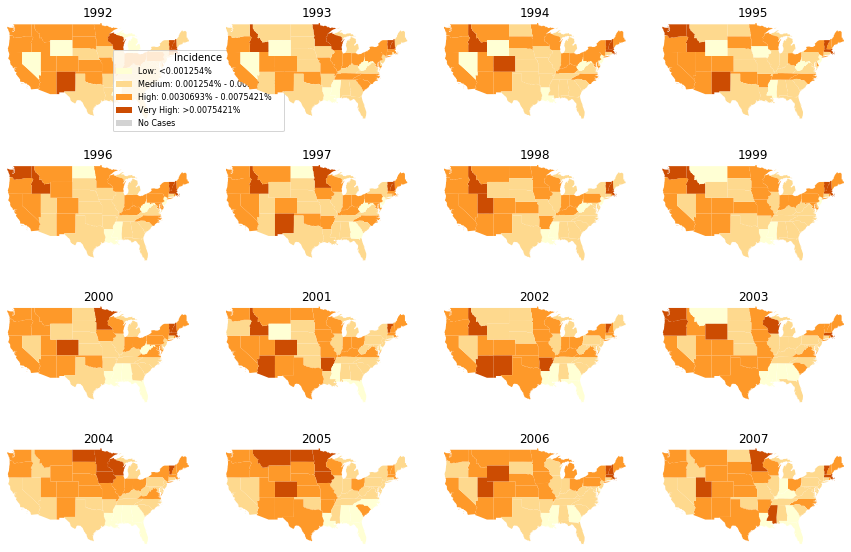

In [38]:
import matplotlib as mpl
import matplotlib.patches as mpatches

fig, ax = plt.subplots(4,4,figsize = (15,10))
ax = ax.ravel()
col = []
for options in np.sort(us_states['bin'+'1992'].unique()):
    col.append(color_mapping[options])
cmap = mpl.colors.ListedColormap(col)
for in_year, year in enumerate(range(1992, 2008)):
    us_states.plot( column = 'bin'+str(year),
                    cmap = cmap,ax=ax[in_year],
            legend = False)

    ax[in_year].axis('off')

    ax[in_year].margins(0)
    ax[in_year].set_title(str(year))
    if year == 1992:
        low = mpatches.Patch( facecolor=color_mapping['Low'],
                                   label='Low: <'+low_percentage)
        med= mpatches.Patch( facecolor=color_mapping['Medium'],
                              label='Medium: '+low_percentage + ' - ' + med_percentage)
        high = mpatches.Patch(facecolor=color_mapping['High'],
                                      label='High: '+med_percentage + ' - ' + high_percentage)
        vhigh = mpatches.Patch(facecolor=color_mapping['Very High'],
                                     label='Very High: >'+high_percentage)

        no = mpatches.Patch(facecolor=color_mapping['No Cases'],
                                     label='No Cases')

        ax[in_year].legend(handles = [low, med, high, vhigh, no], 
                 ncol = 1,loc = 'center',
                  bbox_to_anchor=(1.05, 0.3), fontsize = 8,
                   title = 'Incidence')

In [39]:
us_states['total_years_vhigh'] = (us_states[['bin'+str(year) for year in range(1992,2008)]]=='Very High').sum(axis = 1)

us_states['total_years_low'] = (us_states[['bin'+str(year) for year in range(1992,2008)]]=='Low').sum(axis = 1)

In [40]:
us_states[['State_Name','total_years_low'] ].sort_values(by='total_years_low', ascending=False).head(n=4)

,State_Name,total_years_low
22,MISSISSIPPI,12
16,LOUISIANA,12
46,WEST VIRGINIA,7
9,GEORGIA,7


In [41]:
us_states[['State_Name','total_years_vhigh'] ].sort_values(by='total_years_vhigh', ascending=False).head(n=4)

,State_Name,total_years_vhigh
43,VERMONT,14
19,MASSACHUSETTS,10
27,NEW HAMPSHIRE,9
10,IDAHO,9


# Calculating EWS 

In [42]:
from scipy.stats import iqr

def silvermans(x):
    each_loc = np.zeros(np.shape(x)[1])
    for index_x in range(np.shape(x)[1]):
        each_loc[index_x] = 1.06*np.minimum(np.nanstd(x[:,index_x]), 
                                           iqr(x[:,index_x], 
                                                nan_policy='omit')/1.34)*((len(x[:,index_x]))**(-1/5))
    return each_loc
# silvermans(incidence_monthly)



In [43]:
detrend_monthly =incidence_monthly[states].subtract(incidence_monthly['mean_states'].values, 
                                                            axis = 'rows')
detrend_monthly['TIME'] = incidence_monthly['TIME']
detrend_monthly = detrend_monthly.set_index('TIME')

In [44]:
window_size = 74
detrending_gaussian = incidence_monthly[states] - incidence_monthly[states].rolling(window=window_size,
                                                                   win_type='gaussian',
                                                                   center=True).mean(std = np.mean(silvermans(pertussis_monthly[states].values)))
detrending_gaussian['TIME'] = incidence_monthly['TIME']
detrending_gaussian = detrending_gaussian.groupby('TIME').mean()

In [45]:
incidence_mean=incidence_monthly.groupby('TIME').mean()

In [46]:
def autocov(y, w, lag = 1):
    y_shift = y.shift(lag)
    y_shift = y_shift.rename('shift')
    y = y.rename('original')
    df = pd.concat([y, y_shift], axis =1)
    return_dict = {'cov':df.rolling(window = w).cov(pairwise = False)['original'],
                   'corr':df['original'].rolling(center = False,
                                          window = w).corr(df['shift'])
                   }
    return return_dict



In [47]:
high_incidence = us_states[us_states['total_years_vhigh']>=9].sort_values(by='total_years_vhigh', 
                                                                       ascending=False).State_Name.values
low_incidence = us_states[us_states['total_years_low']>=7].sort_values(by='total_years_low', 
                                                                       ascending=False).State_Name.values
# low_incidence = [x for x in low_incidence if x != 'DISTRICT OF COLUMBIA']


In [48]:
low_incidence = ['LOUISIANA', 'MISSISSIPPI', 'GEORGIA', 'WEST VIRGINIA']
high_incidence = ['VERMONT', 'MASSACHUSETTS', 'IDAHO', 'NEW HAMPSHIRE']
high_col = ['#d7b5d8','#df65b0','#dd1c77','#980043']
low_col = ['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [50]:
incidence_mean=incidence_monthly.groupby('TIME').mean()
spatial_detrend = {}
gaussian_detrend = {}
window_size=74
var_spatial = (detrend_monthly**2).rolling(window = window_size, min_periods=1,
                                          center = False).mean()
spatial_detrend['variance'] = var_spatial.reset_index()
gaussian_detrend_var = (detrending_gaussian**2).rolling(window = window_size, min_periods=1,
                                                       center = False).mean()
gaussian_detrend['variance'] = gaussian_detrend_var.reset_index()

cv_spatial = (detrend_monthly).rolling(window = window_size, min_periods=1,
                                         center = False).std()/incidence_mean.rolling(window = window_size, 
                                                                                      min_periods=1,
                                                                                     center = False).mean()
spatial_detrend['CoV'] = cv_spatial.reset_index()
gaussian_detrend_cv = (detrending_gaussian).rolling(window = window_size, 
                                                    min_periods=1,
                                                    center = False).std()/incidence_mean.rolling(window = window_size,
                                                                                                 min_periods=1,
                                                                                                center = False).mean()
gaussian_detrend['CoV']  = gaussian_detrend_cv.reset_index()

ac_1 = detrend_monthly.copy()
for s in states:
    ac_1[s] = autocov(detrend_monthly[s].shift(1), window_size)['corr'].to_frame()[0]
spatial_detrend['AC(1)'] = ac_1.reset_index()

ac_1_gaussian = detrending_gaussian.copy()
for s in states:
    ac_1_gaussian[s] = autocov(detrending_gaussian[s].shift(1), window_size)['corr'].to_frame()[0]
gaussian_detrend['AC(1)'] = ac_1_gaussian.reset_index()


In [51]:
kendall_tau_stat = {}
for stat in ['variance','CoV', 'AC(1)']:
    print(stat)
    ktau_state_spatial = {}
    ktau_state_gaussian = {}
    for state in states:
        state_data = spatial_detrend[stat]
        state_data = state_data[['TIME', state]]
        ktau_state_spatial[state] = state_data.loc[(state_data['TIME']>1991) & (state_data['TIME']<2008)].corr(method = 'kendall').loc['TIME', state]

        state_data = gaussian_detrend[stat]
        state_data = state_data[['TIME', state]]
        ktau_state_gaussian[state] = state_data.loc[(state_data['TIME']>1991) & (state_data['TIME']<2008)].corr(method = 'kendall').loc['TIME', state]
    
    df_ktau = pd.concat([pd.DataFrame(ktau_state_spatial, index = ['spatial']
            ), pd.DataFrame(ktau_state_gaussian, index=['gaussian'])])
    df_ktau = df_ktau.T
    df_ktau = df_ktau.reset_index()
    df_ktau['states'] = df_ktau['index']
    kendall_tau_stat[stat] = df_ktau

variance
CoV
AC(1)


/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


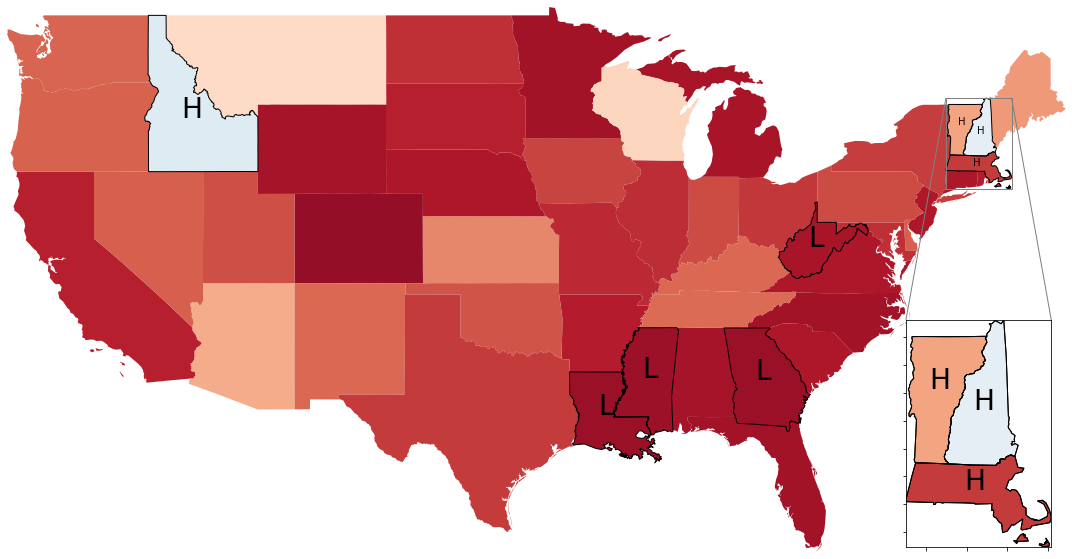

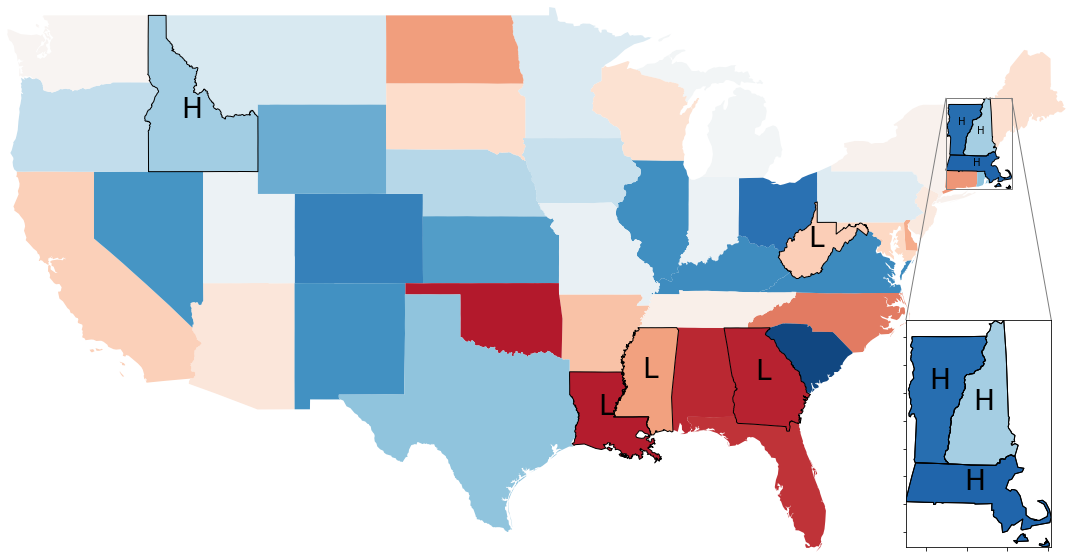

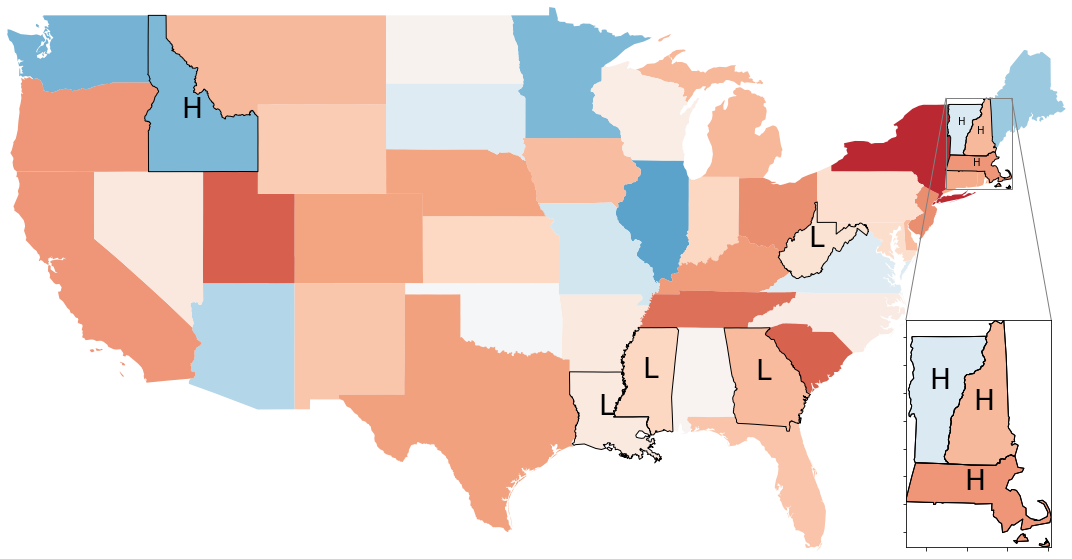

In [52]:
for stat_ind, stat in enumerate(['variance', 'CoV', 'AC(1)']):

    f, ax = plt.subplots(figsize=(15, 10))
    df = kendall_tau_stat[stat]
    df[stat+'_spatial'] = df['spatial']
    us_states_plot = us_states.merge(df, left_on='State_Name', right_on='index', how='left')
    us_states_plot.plot(ax=ax, column = stat+'_spatial', cmap = 'RdBu_r', legend = False,
                        vmax = 1, vmin =-1)
#                         , 
#                   legend_kwds={'shrink': 0.5, 'label':'Kendall-tau score'})
    #                        missing_kwds =  dict(color='lightgrey', label='No Data'))
    us_states_plot[us_states_plot['total_years_vhigh']>=9].plot(ax=ax, facecolor ='None', hatch="", edgecolor  ='black')
    us_states_plot[us_states_plot['total_years_low']>=7].plot(ax=ax, facecolor ='None', hatch="", edgecolor  ='black')
    
    us_states_plot[us_states_plot['State_Name']=='IDAHO'].apply(lambda x: ax.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center', 
                                                                                      fontsize = 28),axis=1)
    us_states_plot[us_states_plot['total_years_low']>=7].apply(lambda x: ax.annotate(s='L',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center', 
                                                                                      fontsize = 28),axis=1)
    ax.axis('off')
    ax.margins(0)
    axins2 = zoomed_inset_axes(ax, 2.5, loc=4)
    zoom_states= us_states_plot[us_states_plot['State_Name'].isin(['VERMONT', 'MASSACHUSETTS','NEW HAMPSHIRE' ])]
    # zoom_states = us_states_plot[us_states_plot['State_Name'] == 'VERMONT']
    minx,miny,maxx,maxy =  zoom_states.total_bounds
    axins2.set_xlim(minx, maxx)
    axins2.set_ylim(miny, maxy)
    zoom_states.plot(ax=axins2,  edgecolor='black',column = stat+'_spatial', 
                     cmap = 'RdBu_r', legend = False,
                        vmax = 1, vmin =-1 )
    zoom_states[zoom_states['total_years_vhigh']>=9].plot(ax=axins2, facecolor ='None', hatch="", edgecolor  ='black')
    zoom_states[zoom_states['total_years_vhigh']>=9].apply(lambda x: axins2.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center',
                                                                                    fontsize = 28),axis=1)
    
    zoom_states[zoom_states['total_years_vhigh']>=9].apply(lambda x: ax.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center'),axis=1)

    # axins2.axis('off')
    plt.setp(axins2.get_xticklabels(), visible=False)
    plt.setp(axins2.get_yticklabels(), visible=False)
    axins2.margins(0)
    mark_inset(ax, axins2, loc1=2, loc2=1, fc="none", ec="0.5")
    f.tight_layout()
    f.savefig('spatial_detrending_maps_'+stat+'.pdf',bbox_inches="tight", pad_inches=0)

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


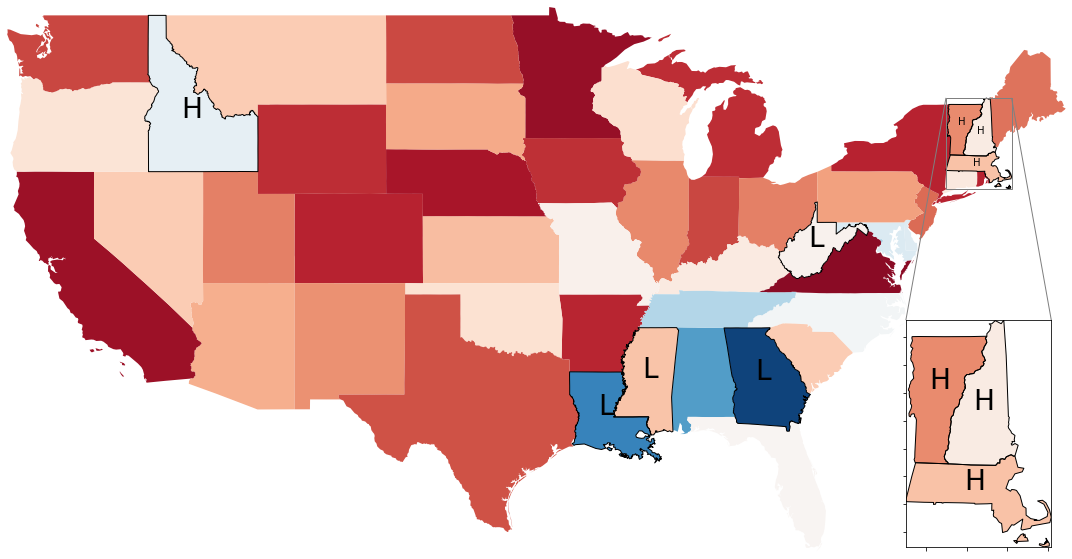

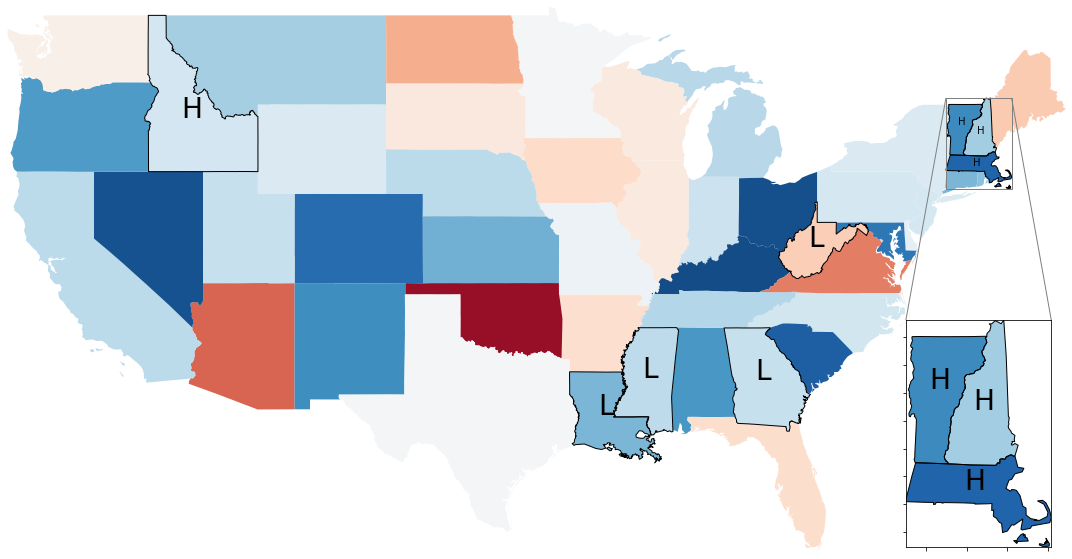

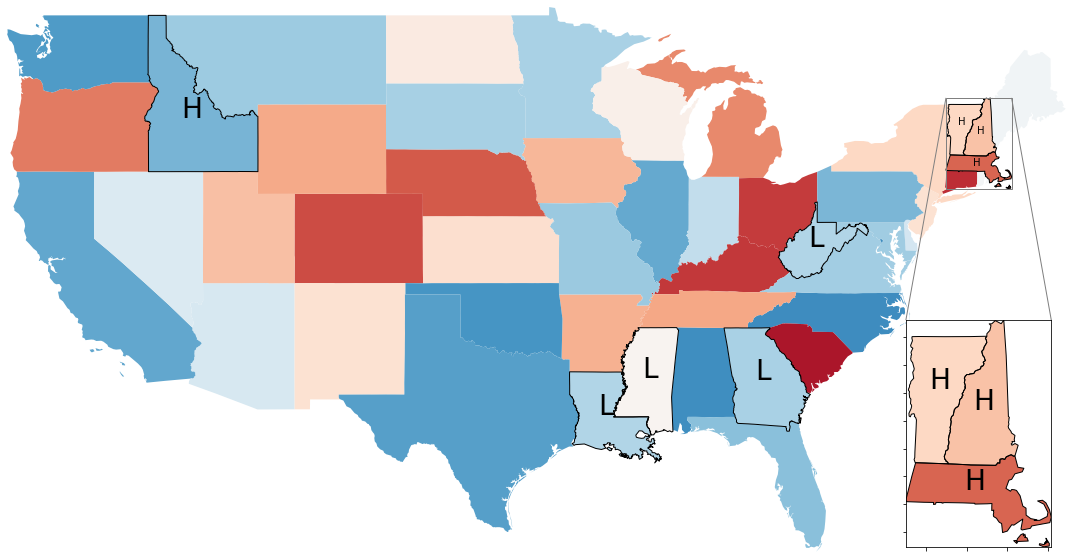

In [53]:
for stat_ind, stat in enumerate(['variance', 'CoV', 'AC(1)']):

    f, ax = plt.subplots(figsize=(15, 10))
    df = kendall_tau_stat[stat]
    df[stat+'_gaussian'] = df['gaussian']
    us_states_plot = us_states.merge(df, left_on='State_Name', right_on='index', how='left')
    mbp = us_states_plot.plot(ax=ax, column = stat+'_gaussian', cmap = 'RdBu_r', legend = False,
                        vmax = 1, vmin =-1)
#                         , 
#                   legend_kwds={'shrink': 0.5, 'label':'Kendall-tau score'})
#                        missing_kwds =  dict(color='lightgrey', label='No Data'))
   
    us_states_plot[us_states_plot['total_years_vhigh']>=9].plot(ax=ax, facecolor ='None', hatch="", edgecolor  ='black')
    us_states_plot[us_states_plot['State_Name']=='IDAHO'].apply(lambda x: ax.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center', 
                                                                                      fontsize = 28),axis=1)
    
    us_states_plot[us_states_plot['total_years_low']>=7].plot(ax=ax, facecolor ='None', hatch="", edgecolor  ='black')
    us_states_plot[us_states_plot['total_years_low']>=7].apply(lambda x: ax.annotate(s='L',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center', 
                                                                                      fontsize = 28),axis=1)
    
    ax.axis('off')
    ax.margins(0)
    axins2 = zoomed_inset_axes(ax, 2.5, loc=4)
    zoom_states= us_states_plot[us_states_plot['State_Name'].isin(['VERMONT', 'MASSACHUSETTS','NEW HAMPSHIRE' ])]
    # zoom_states = us_states_plot[us_states_plot['State_Name'] == 'VERMONT']
    minx,miny,maxx,maxy =  zoom_states.total_bounds
    axins2.set_xlim(minx, maxx)
    axins2.set_ylim(miny, maxy)
    zoom_states.plot(ax=axins2,  edgecolor='None',column = stat+'_gaussian', cmap = 'RdBu_r', legend = False,
                        vmax = 1, vmin =-1 )
    zoom_states[zoom_states['total_years_vhigh']>=9].plot(ax=axins2, facecolor ='None', 
                                                          hatch="", edgecolor  ='black')
    
    zoom_states[zoom_states['total_years_vhigh']>=9].apply(lambda x: axins2.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center',
                                                                                    fontsize = 28),axis=1)
    
    zoom_states[zoom_states['total_years_vhigh']>=9].apply(lambda x: ax.annotate(s='H',
                                                                                 xy=x.geometry.centroid.coords[0], 
                                                                                 ha='center'),axis=1)

    # axins2.axis('off')
    plt.setp(axins2.get_xticklabels(), visible=False)
    plt.setp(axins2.get_yticklabels(), visible=False)
    axins2.margins(0)
    mark_inset(ax, axins2, loc1=2, loc2=1, fc="none", ec="0.5")
    f.tight_layout()
    f.savefig('gaussian_detrending_maps_'+stat+'.pdf',bbox_inches="tight", pad_inches=0)

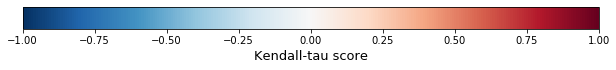

In [54]:
f,a = plt.subplots(figsize = (10,10))
ax = us_states_plot.plot( ax=a,column = stat+'_gaussian', cmap = 'RdBu_r', legend = False,
                        vmax = 1, vmin =-1,legend_kwds={'shrink': 0.5, 'label':'Kendall-tau score'})

fig = ax.get_figure()
cax = fig.add_axes([0.1, 0.1, 0.8, 0.03])
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel('Kendall-tau score', rotation=0, fontsize = 13)
# cax.set_xlabel(r"$[10^{14}\ molec\,cm^{-2}]$", fontname='Arial',
#             fontsize='small', labelpad=-35)
ax.remove()
plt.savefig('plot_onlycbar.pdf', bbox_inches='tight')

# Kendall-tau

In [55]:
def kendall_tau_ews_moving(df, start, end):
    kendall_tau_stat = {}
    for stat in ['variance','CoV', 'AC(1)']:
        ktau_state = {}
        for state in states:
            state_data = df[stat]
            state_data = state_data[['TIME', state]]
            ktau_state[state] = state_data.loc[(state_data['TIME']>=start) &
                                               (state_data['TIME']<=end)].corr(method = 'kendall').loc['TIME', state]

        kendall_tau_stat[stat] = pd.DataFrame(ktau_state, index = [0])
    return kendall_tau_stat


In [56]:
kendall_increasing_results = {}
missi_gaussian  ={}
vermont_gaussian = {}
missi_spatial  ={}
vermont_spatial = {}
for end_date in range(1991, 2003):
    test = kendall_tau_ews_moving(df = gaussian_detrend,
                      start = end_date,
                      end = 2007)
    kendall_increasing_results[end_date] = test
    missi_gaussian[end_date] = pd.concat(test)[['MISSISSIPPI']]
    vermont_gaussian[end_date] = pd.concat(test)[['VERMONT']]
    
    test = kendall_tau_ews_moving(df = spatial_detrend,
                      start = end_date,
                      end = 2007)
    kendall_increasing_results[end_date] = test
    missi_spatial[end_date] = pd.concat(test)[['MISSISSIPPI']]
    vermont_spatial[end_date] = pd.concat(test)[['VERMONT']]  

In [57]:

missi_df_gaussian = pd.concat(missi_gaussian).reset_index().groupby(['level_1','level_0']).mean()
missi_df_spatial = pd.concat(missi_spatial).reset_index().groupby(['level_1','level_0']).mean()
missi_df_gaussian.index.names = ['stat', r'Time t, $EWS \in [t, 2007]$']
missi_df_spatial.index.names = ['stat', r'Time t, $EWS \in [t, 2007]$']


In [58]:
vermont_df_gaussian = pd.concat(vermont_gaussian).reset_index().groupby(['level_1','level_0']).mean()
vermont_df_spatial = pd.concat(vermont_spatial).reset_index().groupby(['level_1','level_0']).mean()
vermont_df_gaussian.index.names = ['stat', r'Time t, $EWS \in [t, 2007]$']
vermont_df_spatial.index.names = ['stat', r'Time t, $EWS \in [t, 2007]$']



In [59]:
vermont_df_spatial['col'] = 1

In [60]:
vermont_df_spatial.loc[(vermont_df_spatial['VERMONT']<0).values,'col']='decreasing'
vermont_df_spatial.loc[(vermont_df_spatial['VERMONT']>=0).values,'col']='increasing'
vermont_df_spatial.xs(stat, level = 0).index.values

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002])

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


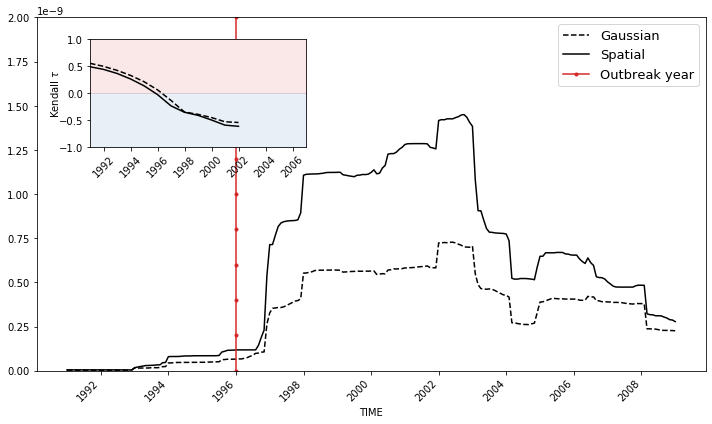

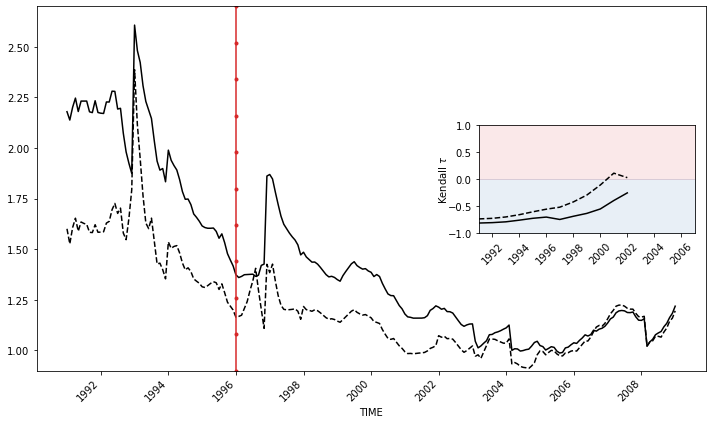

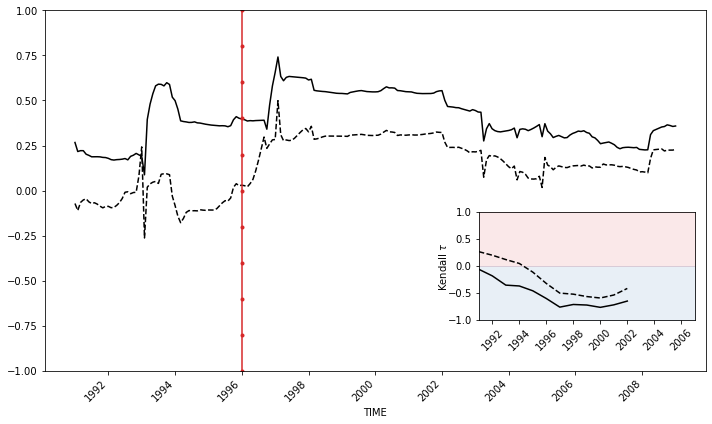

In [61]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
label_title = ['Variance', 'Coefficient of variation', 'Autocorrelation lag-1']
ymax = [2e-9, 2.7, 1]
ymin = [0, 0.9, -1]
inset_locy = [0.65, 0.45, 0.25]
inset_locx = [0.13, 0.67, 0.67]

for istat, stat in enumerate(['variance', 'CoV', 'AC(1)']):
    if stat =='variance':
        legend_value = True
    else:
        legend_value = False
    fig, ax1 = plt.subplots(figsize = (10,6))
    gaussian_detrend[stat][(gaussian_detrend[stat]['TIME']>=1991) & 
                                     (gaussian_detrend[stat]['TIME']<=2009)].plot(ax=ax1, color='k',
                                                                                  x='TIME',
                                                                                  y='VERMONT',
                                                                                 linestyle = '--',
                                                                                 label = 'Gaussian',
                                                                                 legend = legend_value)
    yrdy = spatial_detrend[stat][(spatial_detrend[stat]['TIME']>=1991) & 
                                 (spatial_detrend[stat]['TIME']<=2009)].plot(ax=ax1,
                                                                              x='TIME',
                                                                              y='VERMONT',color='k',
                                                                            label = 'Spatial'
                                                                            , legend=legend_value)
    ax1.plot(1996*np.ones(11), [ymin[istat] + ((ymax[istat]-ymin[istat])/10)*k for k in range(11)],
             '-',marker='.', c='tab:red', label = 'Outbreak year')
    if legend_value:
        ax1.legend(fontsize =13)
    ax1.set_ylim([ymin[istat],ymax[istat]])
    fig.autofmt_xdate(rotation=45)
    yrdy.xaxis.set_major_locator(MaxNLocator(integer=True))

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [inset_locx[istat], inset_locy[istat], 0.3, 0.25]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.set_ylim([-1,1])
    ax2.set_xlim([1991, 2007])
    # ax2.plot(range(6)[::-1], color='green')
    vermont_df_gaussian.xs(stat, level = 0).plot(ax = ax2, y='VERMONT',color='k',
                                                  linestyle = '--', legend =False)
    yy = vermont_df_spatial.xs(stat, level = 0).plot(ax = ax2, y='VERMONT',color='k',
                                                     linestyle = '-',legend = False)
    ax2.fill_between(range(1991, 2008
                          ), 1, 0, color='tab:red', alpha = 0.1)
    ax2.fill_between(range(1991, 2008
                      ), 0, -1, color='#2166ac', alpha = 0.1)
    yy.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.setp(  ax2.xaxis.get_majorticklabels(), rotation=45 )
    ax2.set_ylabel(r'Kendall $τ$', labelpad = -2)
    ax2.set_xlabel('')
#     ax1.set_title(label_title[istat])
    fig.tight_layout()
    fig.savefig('Vermont_timeseries_kendall_tau' +stat+'.pdf')
# plt.setp(  ax[ind].xaxis.get_majorticklabels(), rotation=45 )

/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/emma/anaconda3/envs/2ndphd/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


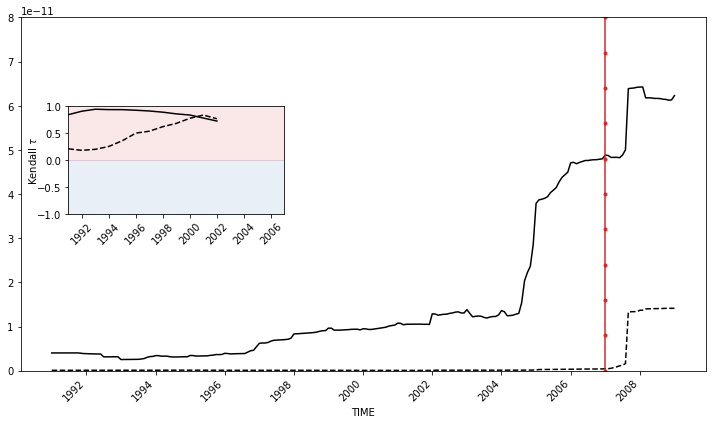

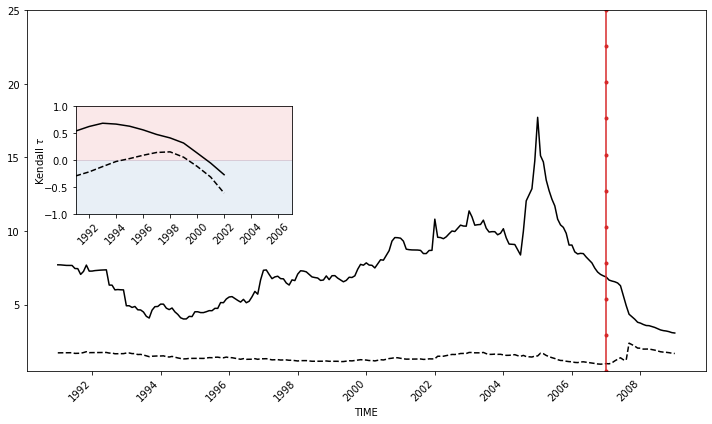

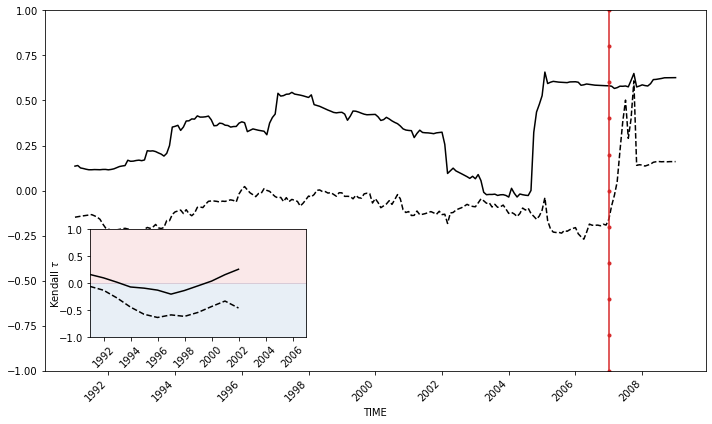

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
label_title = ['Variance', 'Coefficient of variation', 'Autocorrelation lag-1']
ymax = [0.8e-10, 25, 1.]
ymin = [0, 0.5, -1.
       ]
inset_locy = [0.495, 0.495, 0.21]
inset_locx = [0.1, 0.11, 0.13]

for istat, stat in enumerate(['variance', 'CoV', 'AC(1)']):
    fig, ax1 = plt.subplots(figsize = (10,6))
    gaussian_detrend[stat][(gaussian_detrend[stat]['TIME']>=1991) & 
                                     (gaussian_detrend[stat]['TIME']<=2009)].plot(ax=ax1, color='k',
                                                                                  x='TIME',
                                                                                  y='MISSISSIPPI',
                                                                                 linestyle = '--',
                                                                                 label = 'Gaussian',
                                                                                 legend =False)
    yrdy = spatial_detrend[stat][(spatial_detrend[stat]['TIME']>=1991) & 
                                 (spatial_detrend[stat]['TIME']<=2009)].plot(ax=ax1,
                                                                              x='TIME',
                                                                              y='MISSISSIPPI',color='k',
                                                                            label = 'Spatial',
                                                                            legend = False)
    ax1.plot(2007*np.ones(11), [ymin[istat] + ((ymax[istat]-ymin[istat])/10)*k for k in range(11)],
             '-',marker='.', c='tab:red', label = 'Outbreak year')
#     ax1.legend(fontsize = 13)
    ax1.set_ylim([ymin[istat],ymax[istat]])
    fig.autofmt_xdate(rotation=45)
    yrdy.xaxis.set_major_locator(MaxNLocator(integer=True))

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [inset_locx[istat], inset_locy[istat], 0.3, 0.25]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.set_ylim([-1,1])
    ax2.set_xlim([1991, 2007])
    # ax2.plot(range(6)[::-1], color='green')
    missi_df_gaussian.xs(stat, level = 0).plot(ax = ax2, y='MISSISSIPPI', color='k',linestyle = '--', legend =False)
    yy =missi_df_spatial.xs(stat, level = 0).plot(ax = ax2, y='MISSISSIPPI',color='k', linestyle = '-',legend = False)
    ax2.set_ylabel(r'Kendall $τ$', labelpad = -2)
    ax2.set_xlabel('')
    ax2.fill_between(range(1991, 2008
                          ), 1, 0, color='tab:red', alpha = 0.1)
    ax2.fill_between(range(1991, 2008
                      ), 0, -1, color='#2166ac', alpha = 0.1)
    yy.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.setp(  ax2.xaxis.get_majorticklabels(), rotation=45 )
    fig.tight_layout()
#     ax1.set_title(label_title[istat])
    fig.savefig('Missi_timeseries_kendall_tau' +stat+'.pdf')

# Monthly, bimonthly, 6 months, yearly, every 2, 3, 5 years

In [63]:
pertussis_monthly['BIMONTHLY'] = [np.ceil(x/2) for x in pertussis_monthly['MONTH']]
pertussis_monthly['QUARTER'] = [np.ceil(x/3) for x in pertussis_monthly['MONTH']]
pertussis_monthly['THIRD'] = [np.ceil(x/4) for x in pertussis_monthly['MONTH']]
pertussis_monthly['HALF'] = [np.ceil(x/6) for x in pertussis_monthly['MONTH']]
pertussis_monthly['BIYEARLY'] = [x + (x%2) for x in pertussis_monthly['YEAR']]
pertussis_monthly['TRIYEARLY'] = [x +3-(x%3) if (x%3!=0) else x for x in pertussis_monthly['YEAR']]
pertussis_monthly['FIVEYEARLY'] = [x +5-(x%5) if (x%5!=0) else x for x in pertussis_monthly['YEAR']]


In [64]:
def aggregate_data(df, groupby, window_detrend = 0.1, time_month = None):
    df_agg = df.groupby(groupby).sum().reset_index()
    if time_month is None:
        if len(groupby) == 1:
            df_agg['TIME'] = df_agg[groupby[0]]
        else:
            print(groupby)
    else:
        df_agg['TIME'] = df_agg[groupby[0]] + (df_agg[groupby[1]]-1)/time_month
    
    df_incidence = (df_agg.set_index(groupby[0])[states]/
                   census_yearly[states].loc[[x for x in census_yearly.index if x in df_agg[groupby[0]].values]]).reset_index()
    
    df_incidence['YEAR'] = df_agg[groupby[0]].astype(int)
    df_incidence['TIME'] = df_agg['TIME'].astype(float)
    df_incidence['sum_states'] = df_incidence[states].sum(axis=1, skipna =True)
    df_incidence['mean_states'] = df_incidence[states].mean(axis=1, skipna =True)
    
    spatial_detrend = df_incidence[states].subtract(df_incidence['mean_states'].values, axis='rows')
    spatial_detrend['TIME'] = df_incidence['TIME']
    spatial_detrend = spatial_detrend.groupby('TIME').mean()
    window_gaussian = int(df_incidence.shape[0]*window_detrend)
    
#     print('\n window size', window_gaussian)
    gaussian_detrend = df_incidence[states] - df_incidence[states].rolling(window = window_gaussian,
                                                                          win_type='gaussian',
                                                                          center = True).mean(std = np.mean(silvermans(df_agg[states].values)))
    gaussian_detrend['TIME'] = df_incidence['TIME']
    gaussian_detrend = gaussian_detrend.groupby('TIME').mean()
    
    return {'aggregated': df_agg,'incidence':df_incidence, 'spatial': spatial_detrend, 'gaussian': gaussian_detrend}

In [65]:
def ews(df, moving_av, gaussian_window, aggregation, time_agg = None):
    detrend_df = aggregate_data(df = df, 
                               groupby=aggregation,
                               window_detrend=gaussian_window,
                               time_month=time_agg)
    
    #mean incidence needed in CoV calc
    incidence_mean = detrend_df['incidence'].groupby('TIME').mean()
    
    window_size = int(detrend_df['aggregated'].shape[0]*moving_av)
#     print(window_size)
    spatial_ews = {}
    gaussian_ews = {}
    
    #variance
    var_spatial = (detrend_df['spatial']**2).rolling(window = window_size, 
                                                     min_periods=1,
                                                     center = False).mean()
    var_gaussian = (detrend_df['gaussian']**2).rolling(window = window_size,
                                                       min_periods=1,
                                                       center = False).mean()
    spatial_ews['Variance'] = var_spatial.reset_index()
    gaussian_ews['Variance'] = var_gaussian.reset_index()
    
    #CoV
    cv_spatial = (detrend_df['spatial']).rolling(window = window_size, 
                                                    min_periods=1,
                                                    center = False).std()/incidence_mean.rolling(window = window_size, 
                                                                                      min_periods=1,
                                                                                     center = False).mean()
    cv_gaussian = (detrend_df['gaussian']).rolling(window = window_size, 
                                                    min_periods=1,
                                                    center = False).std()/incidence_mean.rolling(window = window_size,
                                                                                                 min_periods=1,
                                                                                               center = False).mean()
    spatial_ews['CoV'] = cv_spatial.reset_index()
    gaussian_ews['CoV'] = cv_gaussian.reset_index()
    
    #AC(1)
    ac_1_spatial = detrend_df['spatial'].copy()
    for s in states:
        ac_1_spatial[s] = autocov(detrend_df['spatial'][s].shift(1), window_size)['corr'].to_frame()[0]
        
    ac_1_gaussian = detrend_df['gaussian'].copy()
    for s in states:
        ac_1_gaussian[s] = autocov(detrend_df['gaussian'][s].shift(1), window_size)['corr'].to_frame()[0]
        
    spatial_ews['AC(1)'] = ac_1_spatial.reset_index()
    gaussian_ews['AC(1)'] = ac_1_gaussian.reset_index()
    
    #kendall-tau scores
    gaussian_dict = kendall_tau_ews(ews_df=gaussian_ews, name='gaussian')
    spatial_dict = kendall_tau_ews(ews_df=spatial_ews, name='spatial')
    
    kendall_tau_scores = {}
    for stat in list(gaussian_dict.keys()):
        df_ktau = pd.concat([spatial_dict[stat], gaussian_dict[stat]])
        df_ktau = df_ktau.T
        df_ktau = df_ktau.reset_index()
        df_ktau['states'] = df_ktau['index']
        kendall_tau_scores[stat] = df_ktau
        
    return {'detrend_dict': detrend_df, 'spatial': spatial_ews, 'gaussian': gaussian_ews, 'kendalltau':kendall_tau_scores}

In [66]:
def kendall_tau_ews(ews_df, name):
    kendall_tau_stat = {}
    for stat in ['Variance','CoV', 'AC(1)']:
        ktau_state = {}
        for state in states:
            state_data = ews_df[stat]
            state_data = state_data[['TIME', state]]
            ktau_state[state] = state_data.loc[(state_data['TIME']>=1991) &
                                               (state_data['TIME']<2006)].corr(method = 'kendall').loc['TIME', state]

        kendall_tau_stat[stat] = pd.DataFrame(ktau_state, index = [name])
    return kendall_tau_stat


In [67]:
monthly = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR', 'MONTH'],
    time_agg = 12)



biagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR', 'BIMONTHLY'],
    time_agg = 6)


thirdagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR', 'THIRD'],
    time_agg = 3)


quarterlyagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR', 'QUARTER'],
    time_agg = 4)


halfagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR', 'HALF'],
    time_agg = 2)

yearagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['YEAR'],
    time_agg = None)

biyearagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['BIYEARLY'],
    time_agg = None) 

threeyearagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['TRIYEARLY'],
    time_agg = None)  

fiveyearagg = ews(df = pertussis_monthly,
    moving_av = 0.2,
    gaussian_window = 0.1,
    aggregation = ['FIVEYEARLY'],
    time_agg = None)   


In [68]:
import seaborn as sns
dataframes_agg = [monthly, biagg, quarterlyagg, thirdagg, halfagg, yearagg, biagg, threeyearagg, fiveyearagg]

agg_names = ['Monthly', 'Bi-monthly', 'Quarterly', 'Triannual',
                                      'Biannual', 'Yearly', 'Biennial', 'Triennial', 'Quinquennial']


ews_function_input = {}
ews_function_input[agg_names[0]] = [['YEAR', 'MONTH'], 12]
ews_function_input[agg_names[1]] = [['YEAR', 'BIMONTHLY'], 6]
ews_function_input[agg_names[2]] = [['YEAR', 'QUARTER'], 4] 
ews_function_input[agg_names[3]] = [['YEAR', 'THIRD'], 3]
ews_function_input[agg_names[4]] = [['YEAR', 'HALF'], 2]
ews_function_input[agg_names[5]] = [['YEAR'], None]
ews_function_input[agg_names[6]] = [['BIYEARLY'], None]
ews_function_input[agg_names[7]] = [['TRIYEARLY'], None]
ews_function_input[agg_names[8]] = [['FIVEYEARLY'], None]


In [69]:
window_sizes_test = np.arange(0.05, 0.8, 0.05)
low_incidence = ['LOUISIANA', 'MISSISSIPPI', 'GEORGIA', 'WEST VIRGINIA']
high_incidence = ['VERMONT', 'MASSACHUSETTS', 'IDAHO', 'NEW HAMPSHIRE']
high_col = ['#d7b5d8','#df65b0','#dd1c77','#980043']
low_col = ['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']

In [ ]:
window_aggregation_spatial = {}
window_aggregation_gaussian = {}
test_loc = low_incidence[1]
print(test_loc)
for stat in (['Variance', 'CoV','AC(1)']):

    spatial_heatmap = np.zeros((len(window_sizes_test), len(agg_names)))
    gaussian_heatmap = np.zeros((len(window_sizes_test), len(agg_names)))
    for index_name, name in enumerate(agg_names):
        for index_av, moving_average_value in enumerate(window_sizes_test):
            
            aggregation_col = ews_function_input[name][0]
            group_time = ews_function_input[name][1]
            try:
                df_results = ews(df = pertussis_monthly,
                                moving_av = moving_average_value,
                                gaussian_window = 0.1,
                                aggregation =aggregation_col,
                                time_agg = group_time)


                dfstat = df_results['kendalltau'][stat]
                dfstat.to_csv((usr+
                               'data/kendall_tau_results_'+
                               name+
                               '_window_size_'+stat+'_'+test_loc+'1991_2005'+
                               str(moving_average_value).replace('.','_')+
                               '.csv'))
#                 dfstat = pd.read_csv((usr+
#                                'data/kendall_tau_results_'+
#                                name+
#                                '_window_size_'+stat+'_'+
#                                str(moving_average_value).replace('.','_')+
#                                '.csv'))
                spatial_heatmap[index_av, index_name] = dfstat[dfstat['states']==test_loc]['spatial'].values[0]
                gaussian_heatmap[index_av, index_name] = dfstat[dfstat['states']==test_loc]['gaussian'].values[0]
            except:
                spatial_heatmap[index_av, index_name] = np.nan
                gaussian_heatmap[index_av, index_name] = np.nan
    window_aggregation_spatial[stat] = spatial_heatmap
    window_aggregation_gaussian[stat] = gaussian_heatmap

In [ ]:
fig,ax = plt.subplots(3,2, figsize = (10, 15))
ax=ax.ravel()
index_stat = 0
for stat in (['Variance', 'CoV','AC(1)']):
        
    df_spatial = pd.DataFrame(window_aggregation_spatial[stat],
                              index=[str(round(frac*100))+'%' for frac in window_sizes_test ], 
                              columns=agg_names)
    df_spatial.index.rename('Window size (% of time series length)', inplace = True)
    mask = df_spatial.isnull()
    g = sns.heatmap(data = df_spatial, mask = mask,
                vmin =-1, vmax =1, cmap ='RdBu_r',ax=ax[index_stat], cbar_kws={'label': 'Kendall-tau score'})
    g.set_facecolor('lightgrey')
    ax[index_stat].set_title(stat + ' (spatial)')

    df_gaussian = pd.DataFrame(window_aggregation_gaussian[stat],
                              index=[str(round(frac*100))+'%' for frac in window_sizes_test ], 
                              columns=agg_names)
    df_gaussian.index.rename('Window size (% of time series length)', inplace = True)
    mask = df_gaussian.isnull()

    g = sns.heatmap(data =df_gaussian ,mask = mask,
                vmin =-1, vmax =1, cmap ='RdBu_r',ax=ax[index_stat+1],cbar_kws={'label': 'Kendall-tau score'})
    g.set_facecolor('lightgrey')
    ax[index_stat+1].set_title(stat +' (gaussian)')
    index_stat =index_stat +2
fig.tight_layout(pad=1.)
fig.savefig('low_risk_time_aggregation_choicewindow.pdf')

In [ ]:
window_aggregation_spatial_highr = {}
window_aggregation_gaussian_highr = {}

for stat in (['Variance', 'CoV','AC(1)']):
    test_loc = high_incidence[0]
    print(test_loc)
    spatial_heatmap = np.zeros((len(window_sizes_test), len(agg_names)))
    gaussian_heatmap = np.zeros((len(window_sizes_test), len(agg_names)))
    for index_name, name in enumerate(agg_names):
        for index_av, moving_average_value in enumerate(window_sizes_test):
            
            aggregation_col = ews_function_input[name][0]
            group_time = ews_function_input[name][1]
            try:
                df_results = ews(df = pertussis_monthly,
                                moving_av = moving_average_value,
                                gaussian_window = 0.1,
                                aggregation =aggregation_col,
                                time_agg = group_time)


                dfstat = df_results['kendalltau'][stat]
                dfstat.to_csv((usr+
                               'data/kendall_tau_results_high_risk_'+
                               name+
                               '_window_size_'+stat+'_'+test_loc+'1991_2005'+
                               str(moving_average_value).replace('.','_')+
                               '.csv'))
                spatial_heatmap[index_av, index_name] = dfstat[dfstat['states']==test_loc]['spatial'].values[0]
                gaussian_heatmap[index_av, index_name] = dfstat[dfstat['states']==test_loc]['gaussian'].values[0]
            except:
                spatial_heatmap[index_av, index_name] = np.nan
                gaussian_heatmap[index_av, index_name] = np.nan
    window_aggregation_spatial_highr[stat] = spatial_heatmap
    window_aggregation_gaussian_highr[stat] = gaussian_heatmap

In [ ]:
fig,ax = plt.subplots(3,2, figsize = (10, 15))
ax=ax.ravel()
index_stat = 0
for stat in (['Variance', 'CoV','AC(1)']):
        
    df_spatial = pd.DataFrame(window_aggregation_spatial_highr[stat],
                              index=[str(round(frac*100))+'%' for frac in window_sizes_test ], 
                              columns=agg_names)
    df_spatial.index.rename('Window size (% of time series length)', inplace = True)
    mask = df_spatial.isnull()
    g = sns.heatmap(data = df_spatial, mask = mask,
                vmin =-1, vmax =1, cmap ='RdBu_r',ax=ax[index_stat],cbar_kws={'label': 'Kendall-tau score'})
    g.set_facecolor('lightgrey')
    ax[index_stat].set_title(stat + ' (spatial)')

    df_gaussian = pd.DataFrame(window_aggregation_gaussian_highr[stat],
                              index=[str(round(frac*100))+'%' for frac in window_sizes_test ], 
                              columns=agg_names)
    df_gaussian.index.rename('Window size (% of time series length)', inplace = True)
    mask = df_gaussian.isnull()

    g = sns.heatmap(data =df_gaussian ,mask = mask,
                vmin =-1, vmax =1, cmap ='RdBu_r',ax=ax[index_stat+1],cbar_kws={'label': 'Kendall-tau score'})
    g.set_facecolor('lightgrey')
    ax[index_stat+1].set_title(stat +' (gaussian)')
    index_stat =index_stat +2
fig.tight_layout(pad=1.)
fig.savefig('high_risk_time_aggregation_choicewindow.pdf')